### Анализ результатов АВ тестов двух рекомендательных систем

В данном иследовании проводится тестирование двух рекомендательных систем.

Первая рекомендательная система тестировалась на группе 2, контрольная группа была 1

Вторая рекомендательная система тестировалась на группе 3, контрольная группы была 0

Даты эксперимента: с 1 мая 2023 года по 7 мая 2023 года

Задача: определить имеются ли различия в ctr между группами тестирования и контрольной

---

#### Анализ результатов между группами 1 и 2

In [1]:
import pandahouse as ph 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
from scipy import stats 
%matplotlib inline

In [2]:
connection = {
                'host': 'https://clickhouse.lab.karpov.courses',
                'database':'simulator_20230520',
                'user':'student', 
                'password':'dpo_python_2020'
            }


q = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

# Выполняем запрос к БД
df_1_2 = ph.read_clickhouse(q, connection=connection)

Посчитаем общий ctr в контрольной группеПосчитаем общий ctr в контрольной группе

In [3]:
ctr_control_1 = df_1_2[df_1_2['exp_group']==1]['likes'].sum() / df_1_2[df_1_2['exp_group']==1]['views'].sum()

Посчитаем в обеих группах поюзерную метрику $$ 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 $$  


In [4]:
df_1_2['linearized_likes'] = df_1_2.apply(lambda row: row['likes'] - ctr_control_1 * row['views'], axis=1)

Выполним визуализацию полученной метрики по группам и посмотрим, заметны ли отличия визуально

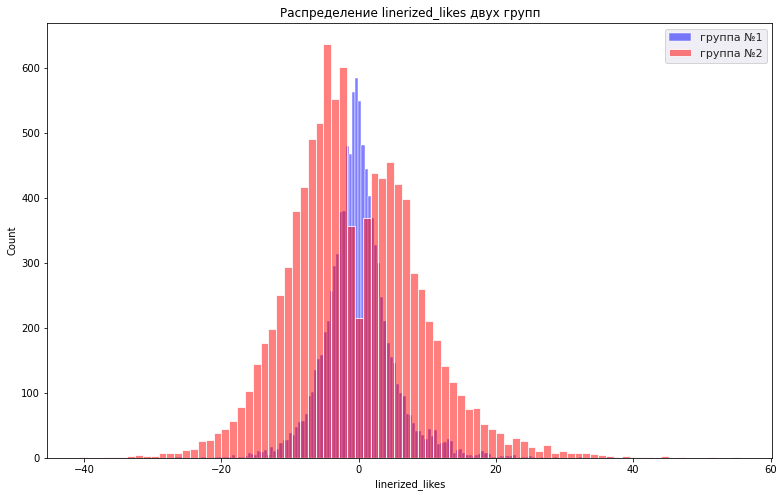

In [5]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.set_theme()
g = sns.histplot(df_1_2[df_1_2['exp_group']==1]['linearized_likes'], color='blue', alpha=0.5, label='группа №1')
g = sns.histplot(df_1_2[df_1_2['exp_group']==2]['linearized_likes'], color='red', alpha=0.5, label='группа №2')
plt.title("Распределение linerized_likes двух групп")
plt.xlabel("linerized_likes")
plt.legend()
plt.show()

Как мы видим на графике, действительно заметны различия между группами, но не понятно в какую из сторон, т.к. характер распределения метрики `linerized_likes` второй группы бимодальный и имеет больший диапазон значений.

Сравним получившиеся значения `t-тестом` по новой метрике, для выявления отличий 

In [6]:
group_1 = df_1_2[df_1_2['exp_group']==1]['linearized_likes']
group_2 = df_1_2[df_1_2['exp_group']==2]['linearized_likes']
stats.ttest_ind(group_1, group_2, equal_var=False)

Ttest_indResult(statistic=6.122579994775973, pvalue=9.439432187037712e-10)

***Вывод:*** `t-тест` между группами показал отличие в новой метрики, исходя из идеи, если имеются отличия между группами в новой метрики, то и есть отличия между исходной метрикой. Однако в ходе анализа исходной метрики мы убедились, что отличий нет. 

В результате тестирования данной метрики мы получили достаточно оснований, чтобы отклонить нулевую гипотезу (`H0`) и принять альтернативную, далее можно рассматривать идею, о внедрении новой рекомендательной системы на основании исходной метрики.

Т.к. получившая метрика оказалась хуже, то следовательно принимают новый алгоритм будет не целесообразно

---

#### Анализ результатов между группами 0 и 3

In [7]:
connection = {
                'host': 'https://clickhouse.lab.karpov.courses',
                'database':'simulator_20230520',
                'user':'student', 
                'password':'dpo_python_2020'
            }


q = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
'''

# Выполняем запрос к БД
df_0_3 = ph.read_clickhouse(q, connection=connection)

Посчитаем общий ctr в контрольной группе

In [8]:
ctr_control_0 = df_0_3[df_0_3['exp_group']==0]['likes'].sum() / df_0_3[df_0_3['exp_group']==0]['views'].sum()

Посчитаем в обеих группах поюзерную метрику $$ 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 $$

In [9]:
df_0_3['linearized_likes'] = df_0_3.apply(lambda row: row['likes'] - ctr_control_0 * row['views'], axis=1)

Выполним визуализацию полученной метрики по группам и посмотрим, заметны ли отличия визуально

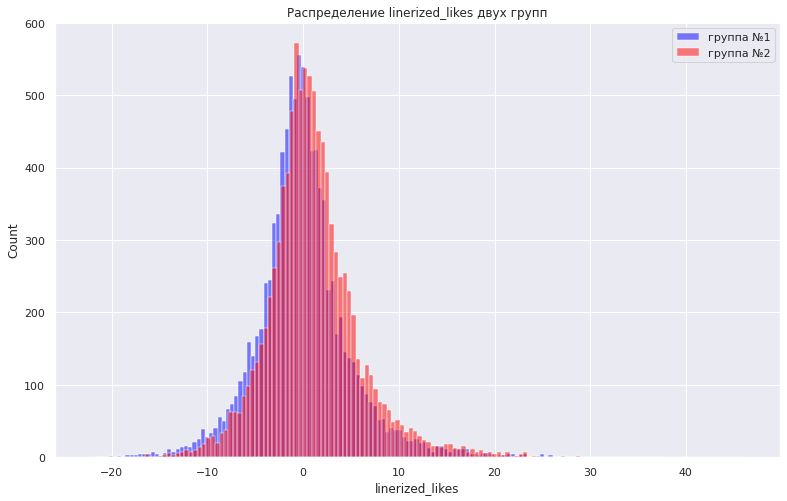

In [10]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.set_theme()
g = sns.histplot(df_0_3[df_0_3['exp_group']==0]['linearized_likes'], color='blue', alpha=0.5, label='группа №1')
g = sns.histplot(df_0_3[df_0_3['exp_group']==3]['linearized_likes'], color='red', alpha=0.5, label='группа №2')
plt.title("Распределение linerized_likes двух групп")
plt.xlabel("linerized_likes")
plt.legend()
plt.show()

Как мы видим наглядно, действительно имеются различия между группами, однако графики выглядят одинаково, но `ctr` второй группы смещен вправо

Сравним получившиеся значения `t-тестом` по новой метрике, для выявления отличий

In [11]:
group_1 = df_0_3[df_0_3['exp_group']==0]['linearized_likes']
group_2 = df_0_3[df_0_3['exp_group']==3]['linearized_likes']
stats.ttest_ind(group_1, group_2, equal_var=False)

Ttest_indResult(statistic=-15.21499546090383, pvalue=5.491424947968532e-52)

***Вывод:*** `t-тест` между группами показал отличие в новой метрики, исходя из идеи, если имеются отличия между группами в новой метрики, то и есть отличия между исходной метрикой. 

В результате тестирования данной метрики мы получили достаточно оснований, чтобы отклонить нулевую гипотезу (`H0`) и принять альтернативную, далее можно рассматривать идею, о внедрении новой рекомендательной системы на основании исходной метрики.

Определим действительно ли новая рекомендательная система лучше, для этого посчитаем `ctr` двух групп по исходной метрике

In [12]:
ctr_0 = df_0_3[df_0_3['exp_group']==0]['likes'].sum() / df_0_3[df_0_3['exp_group']==0]['views'].sum()
ctr_3 = df_0_3[df_0_3['exp_group']==3]['likes'].sum() / df_0_3[df_0_3['exp_group']==3]['views'].sum()

print(f'ctr 0 группы {round(ctr_0, 3)}\nctr 3 группы {round(ctr_3,3)}')

ctr 0 группы 0.208
ctr 3 группы 0.224


***Как мы видим, что `ctr` целевой группы действительно получился лучше и т.к. наш анализ статистической значимости удался, мы отклонили `H0`, то мы имеет все основания утвержать, что вторая рекомендательная система лучше и ее можно вводить в наш сервис***